<a href="https://colab.research.google.com/github/TFITZ57/Capstone_Project/blob/main/Strategy_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [7]:
%pip install coinmetrics-api-client
%pip install backtrader
%pip install pyfolio-reloaded
%pip install ta

In [8]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xvzf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib/
# !./configure --prefix=/usr
# !make
# !make install
# !pip install ta-lib
# %pip install backtesting

In [9]:
import os
from coinmetrics.api_client import CoinMetricsClient
import pandas as pd
import numpy as np
import pyfolio as pf
import datetime
import seaborn as sns
import matplotlib as plt
import ta
import keras
import json
import datetime
import pickle
from itertools import product
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import backtrader as bt
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn.preprocessing import RobustScaler
from google.colab import userdata, drive, files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from backtrader.feeds import PandasData
# from utils import CryptoPandasData

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pipeline

In [10]:
def get_coinmetrics_client_api(): # coinmetrics API client
   # Get tsecret key
    os.environ['COINMETRICS_API_KEY'] = userdata.get('COINMETRICS_API_KEY')
    cm_api_key = os.environ.get('COINMETRICS_API_KEY')
    if cm_api_key is None:
        raise ValueError("cm_api_key not found in the environment.")
    print(f'Coinmetrics Secret Key Successfully Loaded')
    # Instantiate the client with the API key
    client = CoinMetricsClient(cm_api_key)
    return client

client = get_coinmetrics_client_api()

def get_path(file_name): # returns the path to a specified filename
  base_path = '/content/drive/My Drive/mlp_project/colab_files/backtest/'
  file_path = os.path.join(base_path, file_name)
  return file_path

def get_features(assets, quote, exchange, freq, start, end): # returns a dataframe with indicators for all assets defined in a list and saves to csv
    for asset in assets:
      #fetch data
      data = fetch_data(asset, quote, exchange, freq, start, end) # downloads from API, adds indicators

      #add indicators
      data = add_technical_indicators(asset, data)

      #save data
      data.to_csv(get_path(f'{asset.upper()}_ta.csv'))
      print(f'{asset.upper()} Data Saved')

    return data

def fetch_data(asset, quote, exchange, freq, start, end): #Returns 'data', a dataframe with the fetched data and calculated technical indicators
    #get market pair
    market = f'{exchange}-{asset}-{quote}-spot'
    data = client.get_market_candles(
                      markets=market,
                      frequency=freq,
                      start_time=start,
                      end_time=end,
                      page_size=10000
                      ).to_dataframe()

    # process dataframe
    data.set_index('time', inplace=True)
    data.index = pd.to_datetime(data.index, unit='s')
    data.fillna(method='ffill', inplace=True)
    data.dropna(inplace=True)
    data.drop(columns=['market', 'candle_trades_count', 'vwap', 'volume'], inplace=True)
    data = data.rename(columns={'price_open': 'Open', 'price_high': 'High', 'price_low': 'Low', 'candle_usd_volume': 'Volume',  'price_close': 'Close'})
    data = data.reindex(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(f'{asset.upper()} Data Fetch Complete')
    data.to_csv(get_path(f'{asset.upper()}-price_data.csv'))
    print(f'{asset.upper()} Data Saved')

    return data

def calculate_ema(data, span):  #Returns 'data', a dataframe with the calculated EMA
  return data['Close'].ewm(span, adjust=False).mean()

def add_technical_indicators(asset, data): #Returns 'df', the dataframe with technical indicators added
  data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
  bb = ta.volatility.BollingerBands(data['Close'], window=20)
  data['BB_upper'] = bb.bollinger_hband()
  data['BB_middle'] = bb.bollinger_mavg()
  data['BB_lower'] = bb.bollinger_lband()
  data['ULTOSC'] = ta.momentum.ultimate_oscillator(data['High'], data['Low'], data['Close'], window1=7, window2=14, window3=28)
  data['Close_Perc_Variation'] = ((data['Close'] - data['Open']) / data['Open']) * 100
  data['EMA_5'] = calculate_ema(data, 5)
  data['EMA_12'] = calculate_ema(data, 12)
  data['EMA_21'] = calculate_ema(data, 21)
  data['EMA_50'] = calculate_ema(data, 50)
  data['EMA_100'] = calculate_ema(data, 100)
  data['EMA_Cross_1_21'] = data['Close'] - data['EMA_21']
  data['EMA_Cross_1_50'] = data['Close'] - data['EMA_50']
  data['EMA_Cross_12_21'] = data['EMA_12'] - data['EMA_21']
  data['EMA_Cross_12_50'] = data['EMA_12'] - data['EMA_50']
  data['EMA_Cross_20_50'] = data['EMA_21'] - data['EMA_50']
  data['EMA_Cross_50_100'] = data['EMA_50'] - data['EMA_100']
  data['ZScore'] = (data['Close'] - data['Close'].rolling(window=20).mean()) / data['Close'].rolling(window=20).std()
  data['Volume_ZScore'] = (data['Volume'] - data['Volume'].rolling(window=20).mean()) / data['Volume'].rolling(window=20).std()
  print(f'{asset.upper()} Indicators Added')
  data.dropna(inplace=True)

  return data

def load_data(file_name):
    file_path = get_path(file_name)
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Empty data in file: {file_path}")
        return None

    # Check if essential columns are present
    required_columns = ['time', 'Open', 'High', 'Low', 'Close', 'Volume']
    for column in required_columns:
        if column not in df.columns:
            print(f"Column '{column}' is missing in file '{file_name}'")
            return None

    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.dropna(inplace=True)

    # Print the first few rows of the DataFrame to verify it loaded correctly
    print(f"Data for {file_name}:")
    print(df.head())

    return df

def scale_data(data):
  scaler = RobustScaler()
  data_scaled = scaler.fit_transform(data)
  return data_scaled

def get_prediction(asset):
    # Make predictions (assuming you have a trained model)
    predict_prob = model.predict(asset)
    predictions = np.argmax(predict_prob, axis=1)
    return predictions

    # Store predictions in a dictionary with timestamps as keys
    asset_predictions = dict(zip(features.index, predictions))
    predictions_dict[asset] = asset_predictions

def load_data(file_name, start_date=None):
    file_path = get_path(file_name)
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Empty data in file: {file_path}")
        return None

    # Check if essential columns are present
    required_columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    for column in required_columns:
        if column not in df.columns:
            print(f"Column '{column}' is missing in file '{file_name}'")
            return None

    df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
    df.set_index('time', inplace=True)
    df.dropna(inplace=True)

    # Print the initial data
    print("Initial data:")
    print(df.head())

    # Trim the data to start from the earliest prediction timestamp
    if start_date is not None:
        df = df[df.index >= start_date]
        print(f"Data trimmed to start from {start_date}:")
        print(df.head())

    # Print the first few rows of the DataFrame to verify it loaded correctly
    print(f"Data for {file_name}:")
    print(df.head())

    return df

def normalize_datetimes(predictions_dict):
    normalized_dict = {}
    for asset in predictions:
        normalized_timestamps = {ts.replace(tzinfo=None): value for ts, value in timestamps.items()}
        normalized_dict[asset] = normalized_timestamps
    return normalized_dict

def scale_data(data):
  scaler = RobustScaler()
  data_scaled = scaler.fit_transform(data)
  return data_scaled

def get_path(file_name): # returns the path to a specified filename
  base_path = '/content/drive/My Drive/mlp_project/colab_files/backtest/'
  file_path = os.path.join(base_path, file_name)
  return file_path

def load_assets(asset):
  asset_data = pd.read_csv(f'{base_path}{asset}_trade.csv')
  asset_data.set_index = pd.to_datetime(asset_data['time'])
  asset_data.drop(columns=['time'], inplace=True)
  asset_data = pd.DataFrame(asset_data)

  return asset_data

def get_predictions_dict(asset_files):
    predictions_dict = {}
    for asset_name, file_path in asset_files.items():
        try:
            # Load feature dataframes
            features = load_data(file_path)
            print(f"Loaded features for {asset_name}")

            # Scale features (assuming you have a function scale_data)
            features_scaled = scale_data(features)
            print(f"Scaled features for {asset_name}")

            # Make predictions (assuming you have a trained model)
            actions = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
            predict_prob = model.predict(features_scaled)
            predictions = np.argmax(predict_prob, axis=1)
            predictions = [actions[pred] for pred in predictions]
            print(f"Predictions made for {asset_name}")

            # Store predictions in a dictionary with timestamps as keys
            asset_predictions = dict(zip(features.index, predictions))
            predictions_dict[asset_name] = asset_predictions
            def normalize_datetimes(predictions_dict):
                normalized_dict = {}
                for asset, timestamps in predictions_dict.items():
                    normalized_timestamps = {ts.replace(tzinfo=None): value for ts, value in timestamps.items()}
                    normalized_dict[asset] = normalized_timestamps
                return normalized_dict

            normalized_dict = normalize_datetimes(predictions_dict)
            # Save predictions to a pickle file
            with open(f'{base_path}/{asset_name}_predictions.pkl', 'wb') as f:
                pickle.dump(asset_predictions, f)
            print(f"Predictions saved for {asset_name}")

        except Exception as e:
            print(f"Error processing {asset_name}: {e}")

    return predictions_dict_norm

# data = get_features(assets, exchange='binance', quote='usdt', freq='4h', start='2022-01-01', end='2023-01-01')
# df = fetch_data(asset, quote='usdt', exchange='binance', freq ='4h', start ='2022-01-01', end = '2023-01-01

Coinmetrics Secret Key Successfully Loaded


# Generate Predictions

In [11]:
# Prepare data and generate predictions
# base_path = '/content/drive/My Drive/mlp_project/colab_files/backtest/'
# model_path = '/content/drive/My Drive/mlp_project/colab_files/models/randomsearch_1.keras'
# model = load_model(model_path)

# # get predictoion
# ADA = pd.read_csv(get_path('ADA_ta.csv'))
# BNB = pd.read_csv(get_path('BNB_ta.csv'))
# XRP = pd.read_csv(get_path('XRP_ta.csv'))

# ADA.index = pd.to_datetime(ADA['time'])
# BNB.index = pd.to_datetime(BNB['time'])
# XRP.index = pd.to_datetime(XRP['time'])

# ADA.drop(columns=['time'], inplace=True)
# BNB.drop(columns=['time'], inplace=True)
# XRP.drop(columns=['time'], inplace=True)

# ADA_scaled = scale_data(ADA)
# BNB_scaled = scale_data(BNB)
# XRP_scaled = scale_data(XRP)

# ADA_predict = get_prediction(ADA_scaled)
# BNB_predict = get_prediction(BNB_scaled)
# XRP_predict = get_prediction(XRP_scaled)

# with open(f'{base_path}/ada_predictions.pkl', 'wb') as f:
#   pickle.dump(ADA_predict, f)
# with open(f'{base_path}/bnb_predictions.pkl', 'wb') as f:
#   pickle.dump(BNB_predict, f)
# with open(f'{base_path}/xrp_predictions.pkl', 'wb') as f:
#   pickle.dump(XRP_predict, f)

# ADA = pd.read_csv(get_path('ADA_ta.csv'))
# BNB = pd.read_csv(get_path('BNB_ta.csv'))
# XRP = pd.read_csv(get_path('XRP_ta.csv'))
# ADA.index = pd.to_datetime(ADA['time'])
# BNB.index = pd.to_datetime(BNB['time'])
# XRP.index = pd.to_datetime(XRP['time'])

# ADA.drop(columns=['time'], inplace=True)
# BNB.drop(columns=['time'], inplace=True)
# XRP.drop(columns=['time'], inplace=True)
# ADA['labels'] = ADA_predict
# BNB['labels'] = BNB_predict
# XRP['labels'] = XRP_predict

# columns = ['Open', 'High', 'Low', 'Close', 'labels']
# ada_trade = ADA[columns]
# bnb_trade = BNB[columns]
# xrp_trade = XRP[columns]
# ada_trade.to_csv(get_path('ada_trade.csv'))
# bnb_trade.to_csv(get_path('bnb_trade.csv'))
# xrp_trade.to_csv(get_path('xrp_trade.csv'))
# display(ada_trade.head())
# display(bnb_trade.head())
# display(xrp_trade.head())

# Strategies

Total capital: 0.23349353929782432
Operation count: 336
Profitable operations: 98
Max drawdown: -0.02000000000000012
Max profit: 0.3631477101698559
Capital history: [1, 1, 1, 1, 0.978041958041958, 0.978041958041958, 0.978041958041958, 0.978041958041958, 0.9565660716905472, 0.9565660716905472, 0.9565660716905472, 0.9355617537527269, 0.9355617537527269, 0.9355617537527269, 0.9222595301178486, 0.9222595301178486, 0.9222595301178486, 0.9222595301178486, 0.9136490827506587, 0.9136490827506587, 0.9136490827506587, 0.907963222208325, 0.907963222208325, 0.907963222208325, 0.907963222208325, 0.8880261276787158, 0.8880261276787158, 0.8880261276787158, 0.8685268127073091, 0.8685268127073091, 0.8685268127073091, 0.8685268127073091, 0.8685268127073091, 0.8685268127073091, 0.8615698588917667, 0.8615698588917667, 0.8615698588917667, 0.8615698588917667, 0.8615698588917667, 0.8615698588917667, 0.892491522029781, 0.892491522029781, 0.892491522029781, 0.892491522029781, 0.892491522029781, 0.9264797407472

Start date,2022-01-05
End date,2023-01-01
Total months,103
,Backtest
Annual return,-15.535%
Cumulative returns,-76.585%
Annual volatility,19.707%
Sharpe ratio,-0.77
Calmar ratio,-0.20
Stability,0.87
Max drawdown,-78.022%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,78.02,2022-01-17,2022-12-22,NaT,NaN
1,13.84,2022-01-06,2022-01-11,2022-01-17,8
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,-0.06%,-2.20%,36.04%


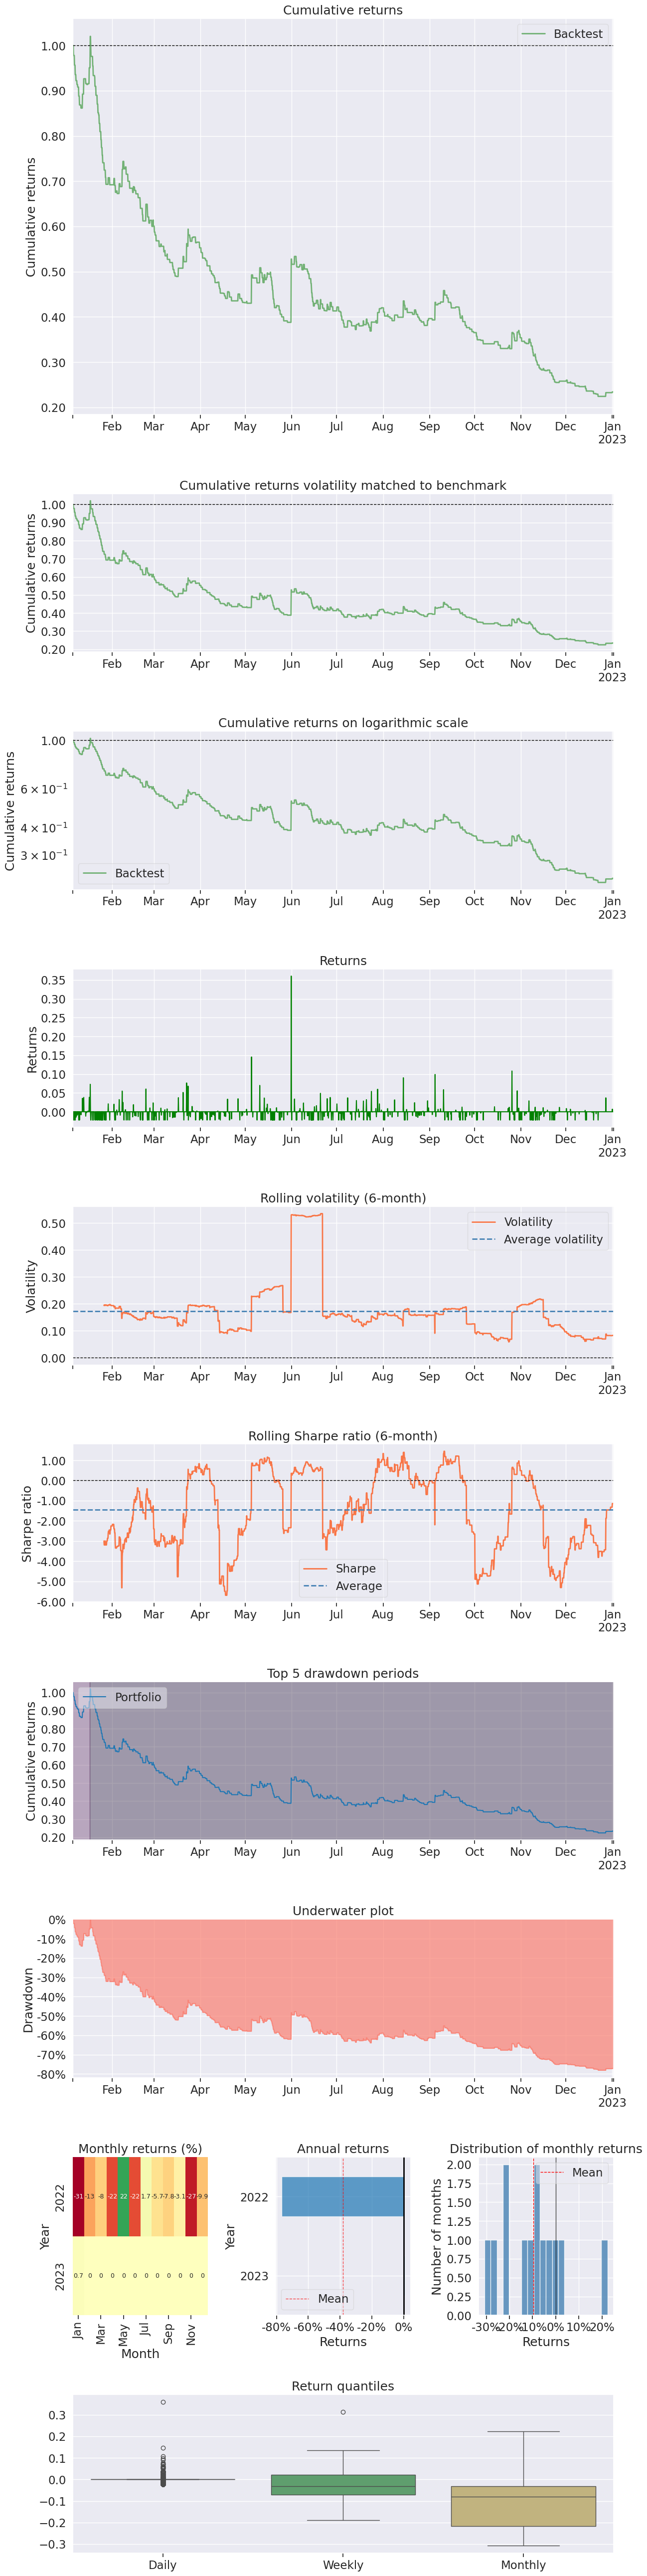

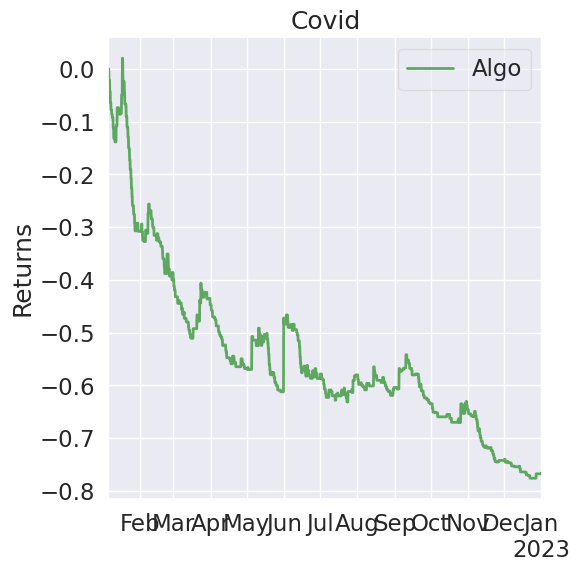

<Figure size 640x480 with 0 Axes>

In [13]:
# Define your BUY_SIGNAL and SELL_SIGNAL constants
BUY_SIGNAL = 1
SELL_SIGNAL = 2
HOLD_SIGNAL = 0
'''
Close issued BUY order if stop loss hit or if at end of forward window is HOLD or SELL label
places buy order of the same amount each trade
'''

def strat_1(df, stop_loss_threshold, transaction_fee):
    df.index = pd.to_datetime(df['time'])
    if not isinstance(df, pd.DataFrame):
        raise TypeError("The input 'df' must be a pandas DataFrame")

    pending_order = False
    start_price =  0
    end_price = 0

    total_capital = 1
    capital_history = []

    min_drawdown = 0
    max_profit = 0
    operation_count = 0
    profitable_operations = 0

    for index, row in df.iterrows():
        # print(f"Processing row: {index}, Label: {row['labels']}")  # Debug print for each row

        # Handle stop loss
        if pending_order:
            end_price = row.Low
            percent_change = (end_price - start_price) / start_price
            if percent_change < -stop_loss_threshold:
                # print(f"Stop loss triggered at {end_price} on {index}")
                pending_order = False

                end_price = start_price * (1 - stop_loss_threshold)

                percent_change = (end_price - start_price) / start_price
                if percent_change < min_drawdown:
                    min_drawdown = percent_change

                total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                        (start_price * (1 + transaction_fee))) /
                                         (start_price * (1 + transaction_fee)))
                start_price = end_price

        capital_history.append(total_capital)

        # Issue BUY order
        if row.labels == BUY_SIGNAL:
            if pending_order:
                continue
            else:
                pending_order = True
                start_price = row.Close
                operation_count += 1
                # print(f"BUY at {start_price} on {index}")  # Debug print for BUY order
                continue

        # Close order if SELL
        if row.labels == SELL_SIGNAL:
            if pending_order:
                end_price = row.Close
                percent_change = (end_price - start_price) / start_price
                if percent_change > 0:
                    profitable_operations += 1

                if percent_change < min_drawdown:
                    min_drawdown = percent_change

                if percent_change > max_profit:
                    max_profit = percent_change

                pending_order = False
                total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                        (start_price * (1 + transaction_fee))) /
                                         (start_price * (1 + transaction_fee)))

                # print(f"SELLl at {end_price} on {index}")
                start_price = 0

    # Handle last candle
    if pending_order:
        end_price = df['Low'].iloc[-1]
        percent_change = (end_price - start_price) / start_price
        if percent_change < -stop_loss_threshold:
            end_price = start_price * (1 - stop_loss_threshold)

        if percent_change < min_drawdown:
            min_drawdown = percent_change

        if percent_change > max_profit:
            max_profit = percent_change

        total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                (start_price * (1 + transaction_fee))) /
                                 (start_price * (1 + transaction_fee)))

    #claulate returns
    if len(capital_history) > 1:
        returns = pd.Series(np.diff(capital_history) / capital_history[:-1], index=df.index[1:])

        print(f"Total capital: {total_capital}")
        print(f"Operation count: {operation_count}")
        print(f"Profitable operations: {profitable_operations}")
        print(f"Max drawdown: {min_drawdown}")
        print(f"Max profit: {max_profit}")
        print(f"Capital history: {capital_history}")  # Debug print for capital history
        print(f"Returns: {returns}")  # Debug print for returns

        pf.create_full_tear_sheet(returns)
        plt.show()
        plt.savefig(get_path('pyfolio_tear_sheet.png'))

    else:
        print("Returns series is empty. No trades executed.")

    return capital_history, total_capital, operation_count, min_drawdown, max_profit, profitable_operations, returns

# Load data and run strategy
asset_data = pd.read_csv(get_path('ada_trade.csv'))
capital_history, final_capital, operation_count, min_drawdown, max_profit, profitable_operations, returns = strat_1(asset_data, 0.02, 0.001)

Total capital: 0.25265002229966893
Operation count: 402
Profitable operations: 151
Max drawdown: 0.006038647342995174
Max profit: 0.1481221481221482
Capital history: [1, 1, 1, 1, 1, 0.978041958041958, 0.978041958041958, 0.978041958041958, 0.978041958041958, 0.9565660716905472, 0.9565660716905472, 0.9565660716905472, 0.9355617537527269, 0.9355617537527269, 0.9355617537527269, 0.9355617537527269, 0.9355617537527269, 0.9436010729635507, 0.9436010729635507, 0.9436010729635507, 0.9436010729635507, 0.9377288138984897, 0.9377288138984897, 0.9377288138984897, 0.9377288138984897, 0.9377288138984897, 0.9171381252576418, 0.9171381252576418, 0.9171381252576418, 0.8969995678219147, 0.8969995678219147, 0.8969995678219147, 0.8969995678219147, 0.8969995678219147, 0.8969995678219147, 0.8773032136753358, 0.8773032136753358, 0.8773032136753358, 0.8773032136753358, 0.8773032136753358, 0.90878954547211, 0.90878954547211, 0.90878954547211, 0.90878954547211, 0.90878954547211, 0.9433984320298142, 0.9433984320

Start date,2022-01-05
End date,2023-01-01
Total months,103
,Backtest
Annual return,-14.824%
Cumulative returns,-74.836%
Annual volatility,14.946%
Sharpe ratio,-1.00
Calmar ratio,-0.20
Stability,0.93
Max drawdown,-75.99%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,75.99,2022-01-17,2022-12-19,NaT,NaN
1,12.27,2022-01-06,2022-01-11,2022-01-17,8
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,-0.06%,-2.20%,14.58%


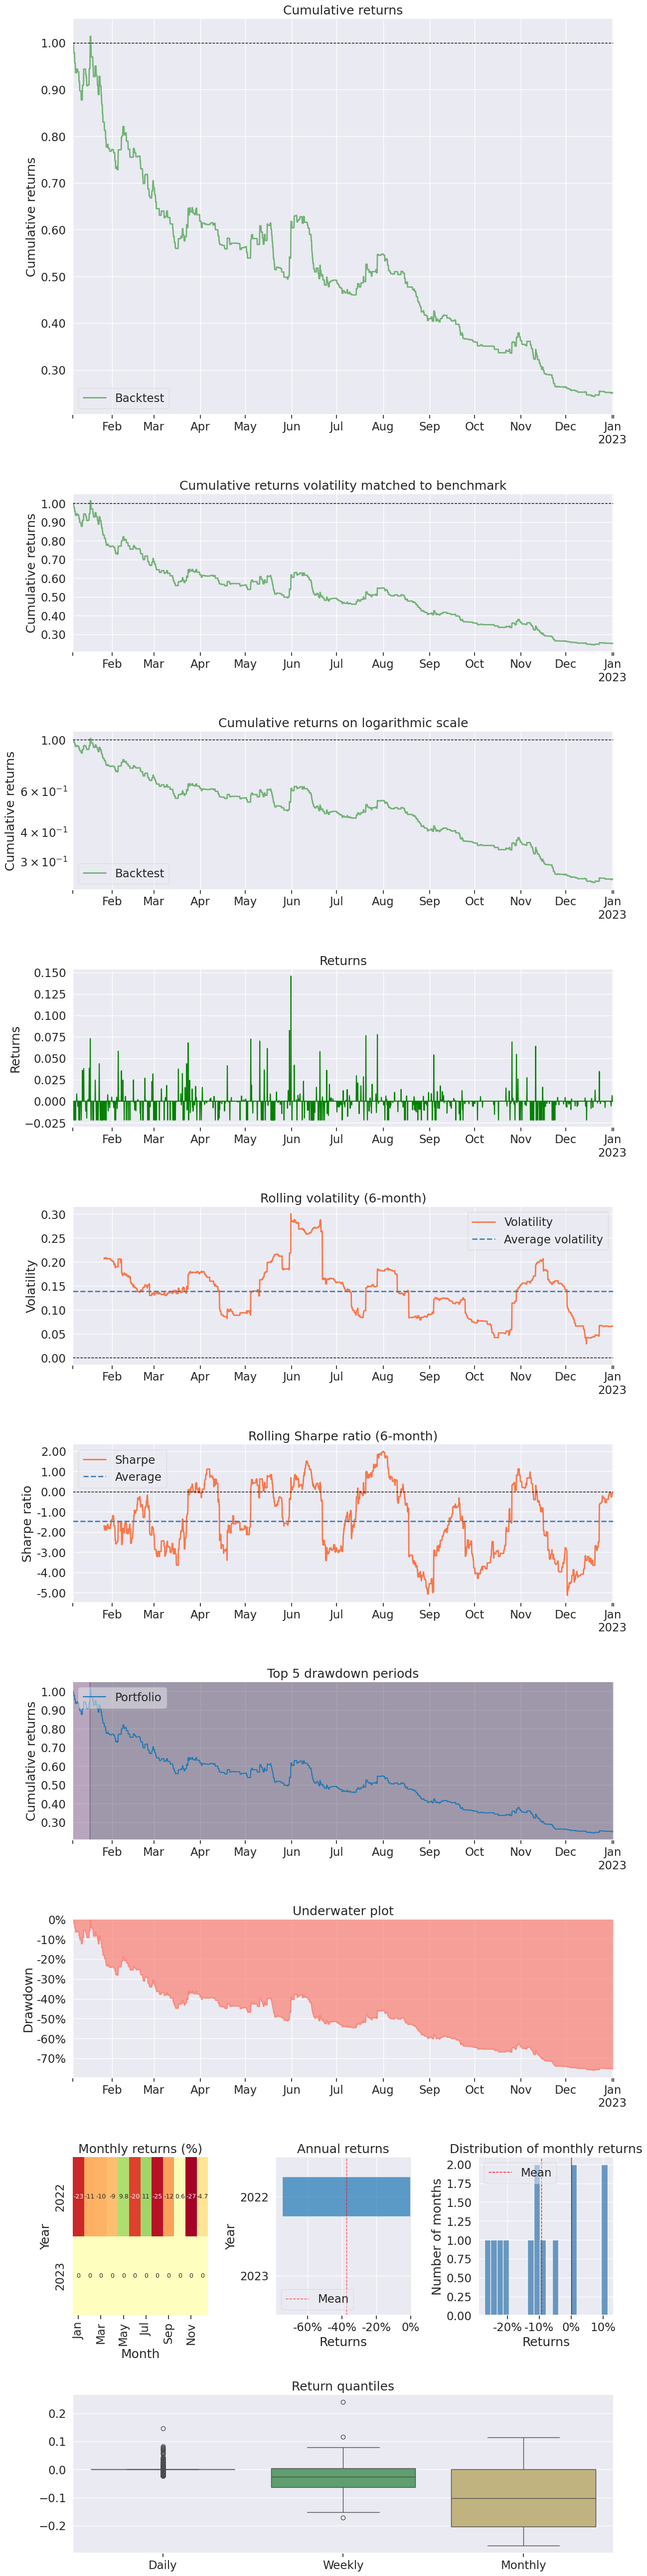

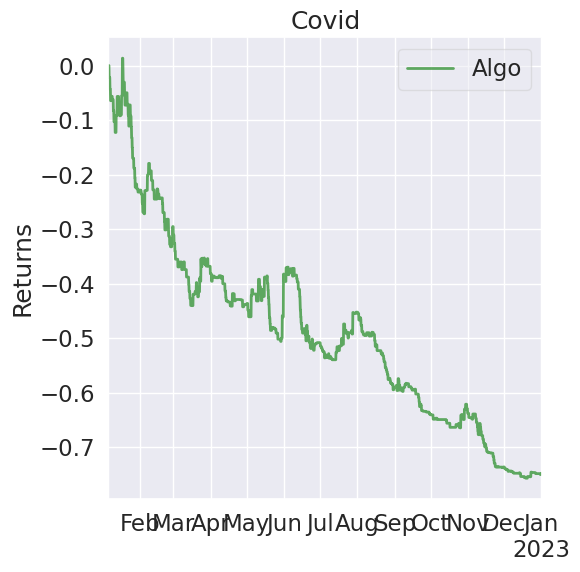

In [15]:
# Define your BUY_SIGNAL and SELL_SIGNAL constants
BUY_SIGNAL = 1
SELL_SIGNAL = 2
HOLD_SIGNAL = 0
'''
Close issued BUY order if stop loss hit or if at end of forward window is HOLD or SELL label
places buy order of the same amount each trade
'''

def strat_2(df, stop_loss_threshold, transaction_fee, forW):
    df.index = pd.to_datetime(df['time'])
    if not isinstance(df, pd.DataFrame):
        raise TypeError("The input 'df' must be a pandas DataFrame")

    pending_order = False
    start_price =  0
    end_price = 0

    total_capital = 1
    capital_history = []

    min_drawdown = 0
    max_profit = 0
    operation_count = 0
    profitable_operations = 0
    forward_position = 0

    for index, row in df.iterrows():
        capital_history.append(total_capital)
        # print(f"Processing row: {index}, Label: {row['labels']}")  # Debug print for each row

        # Handle stop loss
        if pending_order:
            end_price = row.Low
            percent_change = (end_price - start_price) / start_price
            if percent_change < -stop_loss_threshold:
                # print(f"Stop loss triggered at {end_price} on {index}")
                pending_order = False

                end_price = start_price * (1 - stop_loss_threshold)

                percent_change = (end_price - start_price) / start_price
                if percent_change < min_drawdown:
                    min_drawdown = percent_change

                total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                        (start_price * (1 + transaction_fee))) /
                                         (start_price * (1 + transaction_fee)))
                forward_position = 0

        #handle forward window
        if pending_order:
            if forward_position < forW:
                forward_position += 1
                continue

            elif forward_position == forW:
                if row.labels == BUY_SIGNAL:
                    forward_position == 0
                    continue

        # Issue BUY order
        if row.labels == BUY_SIGNAL:
            if pending_order:
                forward_position += 1
                continue

            else:
                pending_order = True
                start_price = row.Close
                operation_count += 1
                forward_position == 0
                # print(f"BUY at {start_price} on {index}")  # Debug print for BUY order
                continue

        # Close order if SELL
        if row.labels == SELL_SIGNAL or row.labels == HOLD_SIGNAL:
            if pending_order:
                end_price = row.Close
                percent_change = (end_price - start_price) / start_price
                if percent_change > 0:
                    profitable_operations += 1

                if percent_change > min_drawdown:
                    max_drawdown = percent_change

                if percent_change > max_profit:
                    max_profit = percent_change

                pending_order = False
                total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                      (start_price * (1 + transaction_fee))) /
                                       (start_price * (1 + transaction_fee)))
                # print(f"SELLl at {end_price} on {index}")
                start_price = 0

    # Handle last candle
    if pending_order:
        end_price = df['Low'].iloc[-1]
        percent_change = (end_price - start_price) / start_price
        if percent_change < -stop_loss_threshold:
            end_price = start_price * (1 - stop_loss_threshold)

        if percent_change < min_drawdown:
            min_drawdown = percent_change

        if percent_change > max_profit:
            max_profit = percent_change

        total_capital *= 1 + (((end_price * (1 - transaction_fee)) -
                                (start_price * (1 + transaction_fee))) /
                                 (start_price * (1 + transaction_fee)))

    #claulate returns
    if len(capital_history) > 1:
        returns = pd.Series(np.diff(capital_history) / capital_history[:-1], index=df.index[1:])
        print(f"Total capital: {total_capital}")
        print(f"Operation count: {operation_count}")
        print(f"Profitable operations: {profitable_operations}")
        print(f"Max drawdown: {max_drawdown}")
        print(f"Max profit: {max_profit}")
        print(f"Capital history: {capital_history}")  # Debug print for capital history
        print(f"Returns: {returns}")  # Debug print for returns

    # if not returns.empty:
        pf.create_full_tear_sheet(returns)
    else:
        print("Returns series is empty. No trades executed.")

    return capital_history, total_capital, operation_count, max_drawdown, max_profit, profitable_operations, returns


# Example of running the function
asset_data = pd.read_csv(get_path('ada_trade.csv'))
capital_history, total_capital, operation_count, min_drawdown, max_gain, profitable_operations, returns = strat_2(asset_data, 0.02, 0.001, 2)

In [21]:
# Define your BUY_SIGNAL and SELL_SIGNAL constants
# BUY_SIGNAL = 1
# SELL_SIGNAL = -1
# HOLD_SIGNAL = 0

def cumulative_strat_3(df, stop_loss_threshold, transaction_fee, forward_window_period):
    def correct_labels(labels):
        """
        Correct labels in a way that the one at the start of the forward window must be -1
        the other, to the end of window must be 0
        :param labels:
        :return:
        """
        arr = np.zeros(len(labels))
        result = np.where(labels == SELL_SIGNAL)
        idxs = result[0]

        pos = 0
        try:
            for idx in idxs:
                if idx <= pos:
                    continue

                arr[idx] = SELL_SIGNAL
                pos = idx + forward_window_period
        except Exception as ex:
            print(ex)

        arr[len(labels) - 1] = HOLD_SIGNAL

        return arr

    if not isinstance(df, pd.DataFrame):
        raise TypeError("The input 'df' must be a pandas DataFrame")

    df['Labels'] = correct_labels(df['labels'])
    df['CloseP'] = df['Close'].shift(-1 * forward_window_period)
    df['Returns'] = ((df['CloseP'] * (1 - transaction_fee)) -
                      (df['Close'] * (1 + transaction_fee))) / \
                        (df['Close'] * (1 + transaction_fee)) * -df['labels']

    print(df.head())

    return list[df['Returns']], np.prod(df[df['Returns'] != 0]['Returns'].dropna() + 1), len(df[df['Returns'] == -1]),\
           np.min(df[df['Returns'] != 0]['Returns'].dropna()), np.max(df[df['Returns'] != 0]['Returns'].dropna()), -1

    print(df.head())

# load data and run strategy
asset_data = pd.read_csv(get_path('ada_trade.csv'))
cumulative_strat_3(asset_data, 0.02, 0.001, 2)

                        time   Open   High    Low  Close  labels  Labels  \
0  2022-01-05 16:00:00+00:00  1.327  1.329  1.244  1.256       2     0.0   
1  2022-01-05 20:00:00+00:00  1.256  1.267  1.193  1.230       2     2.0   
2  2022-01-06 00:00:00+00:00  1.230  1.244  1.203  1.204       2     0.0   
3  2022-01-06 04:00:00+00:00  1.204  1.233  1.197  1.223       1     0.0   
4  2022-01-06 08:00:00+00:00  1.223  1.225  1.192  1.204       2     2.0   

   CloseP   Returns  
0   1.204  0.086633  
1   1.223  0.015355  
2   1.204  0.003996  
3   1.233 -0.006162  
4   1.248 -0.068948  


(list[0       0.086633
 1       0.015355
 2       0.003996
 3      -0.006162
 4      -0.068948
           ...   
 2163    0.000000
 2164    0.000000
 2165    0.000000
 2166         NaN
 2167         NaN
 Name: Returns, Length: 2168, dtype: float64],
 59.79392349856179,
 0,
 -0.24965845534865644,
 0.3280816300543158,
 -1)